### The model

$u(c) = log(c)$ utility function    
$y = 1$ Deterministic income    
$p(r = 0.02) = 0.5$   
$p(r = -0.01) = 0.5$ 

### value iteration 

In [1]:
# infinite horizon MDP problem
%pylab inline
import numpy as np
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")
def u(c):
    return np.log(c)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# discounting factor 
beta = 0.95
# wealth level
w_low = 1
w_high = 10
# interest rate
r_up = 0.02
r_down = 0.01
# deterministic income
y = 1
# good state and bad state economy with equal probability 0.5
# with good investment return 0.02 or bad investment return -0.01
ws = np.linspace(0.01,10**(0.5),100)**2
Vs = np.zeros(100)
Cs = np.zeros(100)

In [3]:
# Value iteration
for j in range(30):
    if j % 10 == 0:
        print(j)
    for i in range(len(ws)):
        w = ws[i]
        def obj(c):
            return -(u(c) + beta*(np.interp((y+w-c)*(1+r_up), ws, Vs) + np.interp((y+w-c)*(1-r_down), ws, Vs))/2)
        bounds = [(0.0001, y+w-0.0001)]
        res = minimize(obj, 0.0001, method='SLSQP', bounds=bounds)
        Cs[i] = res.x[0]
        Vs[i] = -res.fun

0
10
20


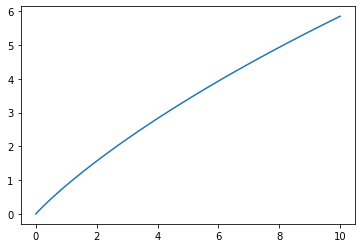

In [4]:
plt.plot(ws,Vs)

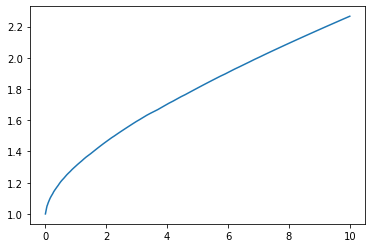

In [5]:
plt.plot(ws,Cs)

### policy gradient
Assume the policy form $\theta = (a,b,c, \sigma =0.1)$, then $\pi_\theta$ ~ $N(log(ax+b)+c, \sigma)$

Assume the initial value $a = 1$, $b = 1$, $c = 1$, $\sigma = 0.1$     


$$\theta_{k+1} = \theta_{k} + \alpha  \nabla_\theta V(\pi_\theta)|\theta_k$$

In [6]:
# simulation step T = 20
T = 20
def mu(theta, w):
    return np.log(theta[0] * w + theta[1]) + theta[2] 

def simSinglePath(theta):
    wPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    w = np.random.choice(ws)
    for t in range(T):
        c = np.random.normal(mu(theta, w), theta[3])
        while c < 0.001 or c > w+y-0.001:
            c = np.random.normal(mu(theta, w), theta[3])
        wPath[t] = w
        aPath[t] = c
        try:
            rPath[t] = np.log(c)*(beta**t)
        except:
            print(c)
        if np.random.uniform(0,1) > 0.5:
            w = (w+y-c) * (1+r_up)
        else:
            w = (w+y-c) * (1-r_down)
    return wPath, aPath, rPath


def gradientV(theta, D = 100):
    '''
        D is the sample size
    '''
    grad = np.zeros(len(theta))
    newGrad = np.zeros(len(theta))
    for d in range(D):
        wp, ap, rp = simSinglePath(theta) 
        newGrad[0] = np.sum((ap - mu(theta, wp))/(theta[3]**2)*(wp/(theta[0]*wp + theta[1])))
        newGrad[1] = np.sum((ap - mu(theta, wp))/(theta[3]**2)*(1/(theta[0]*wp + theta[1])))
        newGrad[2] = np.sum((ap - mu(theta, wp))/(theta[3]**2))
        grad += newGrad * np.sum(rp)
    grad /= D
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta 


def plot1(theta):
    def f(x):
        return np.log(theta[0]*x + theta[1]) + theta[2]
    plt.plot(ws, Cs, 'b')
    plt.plot(ws, f(ws), 'r')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


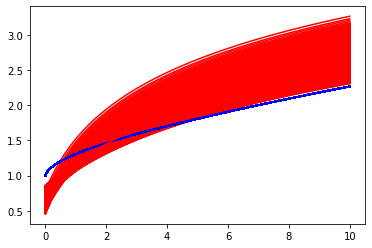

In [7]:
# c < 0 or c > w + 5, then reward -100
N = 10000
# initial theta
theta = [1,1,1,0.2]
# gradient ascend step size
alpha = 0.001
# store theta
THETA1 = np.zeros((3,N))
for i in range(N):
    if i%100 ==0:
        print(i)
    theta = updateTheta(theta)
    THETA1[:,i] = theta[:3]
    plot1(theta)

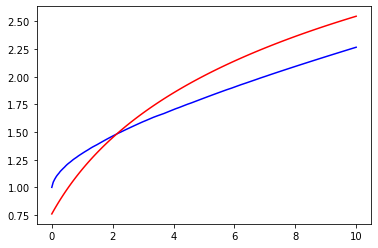

In [8]:
plot1(theta)

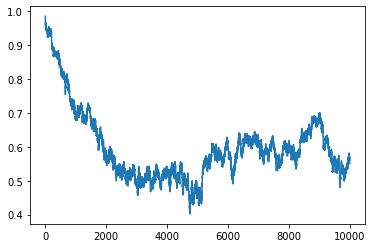

In [9]:
plt.plot(THETA1[0,:])

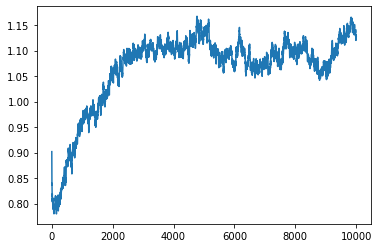

In [10]:
plt.plot(THETA1[1,:])

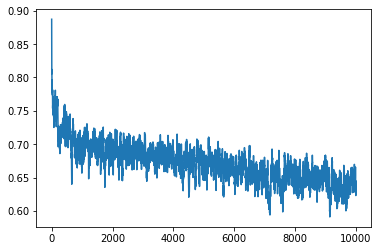

In [11]:
plt.plot(THETA1[2,:])

### policy gradient
Assume the policy form $\theta = (a,b,\sigma = 0.1)$, then $\pi_\theta$ ~ $N(ax+b, \sigma)$

Assume the initial value $a = 1$, $b = 1$, $\sigma = 0.1$     


$$\theta_{k+1} = \theta_{k} + \alpha  \nabla_\theta V(\pi_\theta)|\theta_k$$

In [12]:
# simulation step T = 20
def mu(theta, w):
    return theta[0] * w + theta[1]

def simSinglePath(theta):
    wPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    w = np.random.choice(ws)
    for t in range(T):
        c = np.random.normal(mu(theta, w), theta[2])
        while c < 0.0001 or c > w+y-0.0001:
            c = np.random.normal(mu(theta, w), theta[2])
        wPath[t] = w
        aPath[t] = c
        rPath[t] = np.log(c)*(beta**t)
        if np.random.uniform(0,1) > 0.5:
            w = (w+y-c) * (1+r_up)
        else:
            w = (w+y-c) * (1-r_down)
    return wPath, aPath, rPath


def gradientV(theta, D = 100):
    '''
        D is the sample size
    '''
    grad = np.zeros(len(theta))
    newGrad = np.zeros(len(theta))
    for d in range(D):
        wp, ap, rp = simSinglePath(theta) 
        newGrad[0] = np.sum((ap - mu(theta, wp))/(theta[2]**2)*(wp))
        newGrad[1] = np.sum((ap - mu(theta, wp))/(theta[2]**2)*(1))
        grad += newGrad * np.sum(rp)
    grad /= D
    return grad


def plot2(theta):
    def f(x):
        return theta[0] * x + theta[1]
    plt.plot(ws, Cs, 'b')
    plt.plot(ws, f(ws), 'r')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


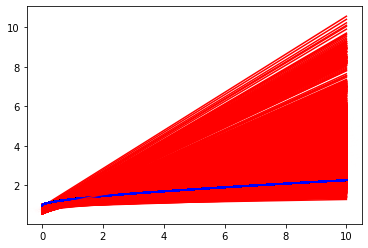

In [13]:
# c < 0 or c > w + 5, then reward -100
# initial theta 
N = 10000
theta = [1,1,0.2]
# gradient ascend step size 
alpha = 0.001
# store theta 
THETA2 = np.zeros((2,N))
for i in range(N):
    if i%100 ==0:
        print(i)
    theta = updateTheta(theta)
    THETA2[:,i] = theta[:2]
    plot2(theta)

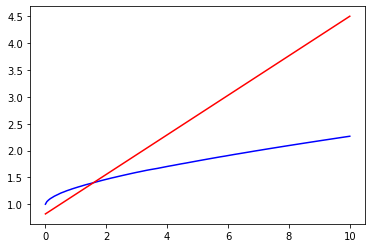

In [14]:
plot2(theta)

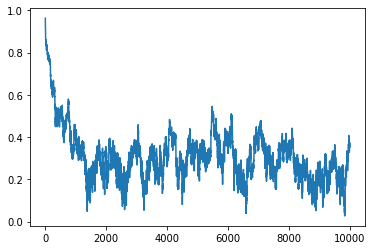

In [15]:
plt.plot(THETA2[0,:])

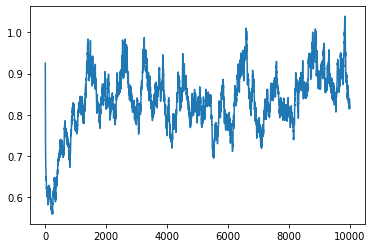

In [16]:
plt.plot(THETA2[1,:])

### policy gradient
Assume the policy form $\theta = (a,b,c,d, \sigma = 0.1)$, then $\pi_\theta$ ~ $N(\frac{1}{1+e^{a w^3 +b w^2 + c w +d}}), \sigma)$

Assume the initial value $a = 1$, $b = 1$, $c = 1$, $d = 1$, $\sigma = 0.01$     


$$\theta_{k+1} = \theta_{k} + \alpha  \nabla_\theta V(\pi_\theta)|\theta_k$$

In [811]:
T = 20
# simulation step T = 20
def poly(theta, w):
    return theta[0] * (w**3) + theta[1] * (w**2) + theta[2] * w + theta[3]

def mu(theta, w):
    return 1 / (1+np.exp(poly(theta, w)))

def simSinglePath(theta):
    wPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    w = np.random.choice(ws)
    for t in range(T):
        n = np.random.normal(mu(theta, w), theta[4])*(w+1)
        while n < 0.01 or n > 0.99:
            n = np.random.normal(mu(theta, w), theta[4])
        c = (w+y)*n
        wPath[t] = w
        aPath[t] = n
        rPath[t] = np.log(c)*(beta**t)
        if np.random.uniform(0,1) > 0.5:
            w = (w+y-c) * (1+r_up)
        else:
            w = (w+y-c) * (1-r_down)
    return wPath, aPath, rPath



def gradientV(theta, D = 100):
    '''
        D is the sample size
    '''
    grad = np.zeros(len(theta))
    newGrad = np.zeros(len(theta))
    for d in range(D):
        wp, ap, rp = simSinglePath(theta) 
        newGrad[0] = np.sum((ap - mu(theta, wp))*(mu(theta, wp)**2 * np.exp(poly(theta, wp)))*(-wp**3))
        newGrad[1] = np.sum((ap - mu(theta, wp))*(mu(theta, wp)**2 * np.exp(poly(theta, wp)))*(-wp**2))
        newGrad[2] = np.sum((ap - mu(theta, wp))*(mu(theta, wp)**2 * np.exp(poly(theta, wp)))*(-wp))
        newGrad[3] = np.sum((ap - mu(theta, wp))*(mu(theta, wp)**2 * np.exp(poly(theta, wp)))*(-1))
        grad += newGrad * np.sum(rp)
    grad /= D
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta 

def plot3(theta):
    def f(x):
        return mu(theta, x)
    plt.plot(ws, Cs, 'b')
    plt.plot(ws, f(ws)*(ws+1), 'r')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


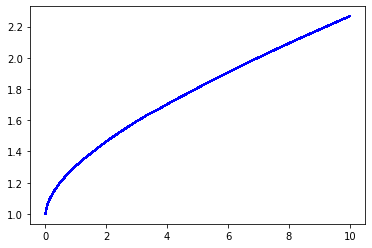

In [812]:
# initial theta 
N = 1000
theta = [1,1,1,1, 0.1]
# gradient ascend step size 
alpha = 0.01
# store theta 
THETA3 = np.zeros((4,N))
for i in range(N):
    if i%10 ==0:
        print(i)
    theta = updateTheta(theta)
    THETA3[:,i] = theta[:4]
    plot3(theta)

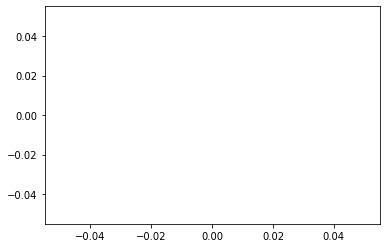

In [813]:
plt.plot(THETA3[0,:])

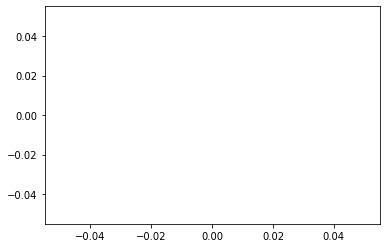

In [814]:
plt.plot(THETA3[1,:])

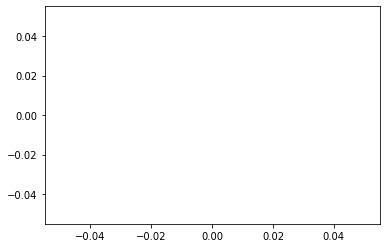

In [815]:
plt.plot(THETA3[2,:])

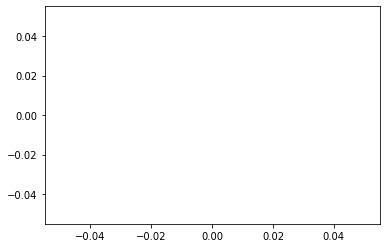

In [816]:
plt.plot(THETA3[3,:])

In [817]:
theta

array([nan, nan, nan, nan, nan])

### policy gradient
Assume the policy form $\theta = (a,b,c,d, \sigma = 0.1)$, then $\pi_\theta$ ~ $N(\frac{1}{1+e^{a w^2 +b w + c}}, \sigma)$

Assume the initial value $a = 1$, $b = 1$, $c = 1$, $\sigma = 0.1$     


$$\theta_{k+1} = \theta_{k} + \alpha  \nabla_\theta V(\pi_\theta)|\theta_k$$

In [818]:
T = 20
# simulation step T = 20
def poly(theta, w):
    return theta[0] * (w**2) + theta[1] * w + theta[2]

def mu(theta, w):
    return 1 / (1+np.exp(poly(theta, w)))

def simSinglePath(theta):
    wPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    w = np.random.choice(ws)
    for t in range(T):
        n = np.random.normal(mu(theta, w), theta[-1])*(w+1)
        while n < 0.01 or n > 0.99:
            n = np.random.normal(mu(theta, w), theta[-1])
        c = (w+y)*n
        wPath[t] = w
        aPath[t] = n
        rPath[t] = np.log(c)*(beta**t)
        if np.random.uniform(0,1) > 0.5:
            w = (w+y-c) * (1+r_up)
        else:
            w = (w+y-c) * (1-r_down)
    return wPath, aPath, rPath



def gradientV(theta, D = 100):
    '''
        D is the sample size
    '''
    grad = np.zeros(len(theta))
    newGrad = np.zeros(len(theta))
    for d in range(D):
        wp, ap, rp = simSinglePath(theta) 
        newGrad[0] = np.sum((ap - mu(theta, wp))*(mu(theta, wp)**2 * np.exp(poly(theta, wp)))*(-wp**2))
        newGrad[1] = np.sum((ap - mu(theta, wp))*(mu(theta, wp)**2 * np.exp(poly(theta, wp)))*(-wp))
        newGrad[2] = np.sum((ap - mu(theta, wp))*(mu(theta, wp)**2 * np.exp(poly(theta, wp)))*(-1))
        grad += newGrad * np.sum(rp)
    grad /= D
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta 

def plot3(theta):
    def f(x):
        return mu(theta, x)
    plt.plot(ws, Cs, 'b')
    plt.plot(ws, f(ws)*(ws+1), 'r')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


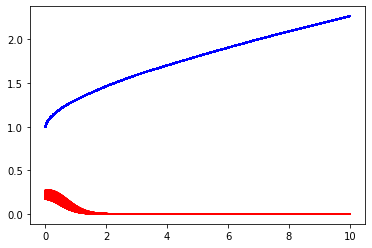

In [819]:
# initial theta 
N = 1000
theta = [1,1,1, 0.1]
# gradient ascend step size 
alpha = 0.01
# store theta 
THETA3 = np.zeros((3,N))
for i in range(N):
    if i%10 ==0:
        print(i)
    theta = updateTheta(theta)
    THETA3[:,i] = theta[:3]
    plot3(theta)

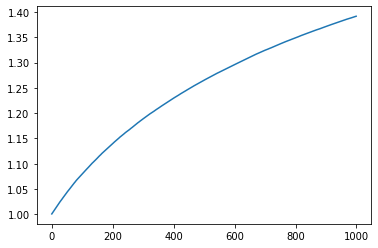

In [820]:
plt.plot(THETA3[0,:])

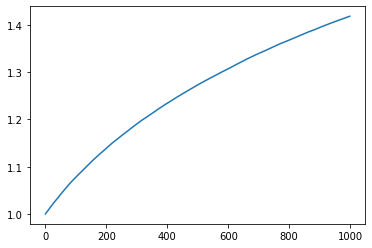

In [821]:
plt.plot(THETA3[1,:])

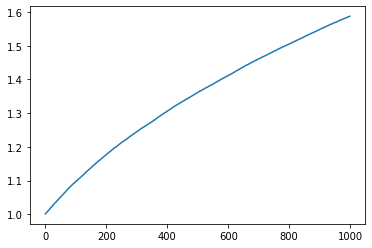

In [822]:
plt.plot(THETA3[2,:])

In [823]:
theta

array([1.39180244, 1.41789652, 1.58735541, 0.1       ])

In [824]:
T = 20
# simulation step T = 20
def poly(theta, w):
    return theta[0] * w + theta[1]

def mu(theta, w):
    return 1 / (1+np.exp(poly(theta, w)))

def simSinglePath(theta):
    wPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    w = np.random.choice(ws)
    for t in range(T):
        n = np.random.normal(mu(theta, w), theta[-1])*(w+1)
        while n < 0.01 or n > 0.99:
            n = np.random.normal(mu(theta, w), theta[-1])
        c = (w+y)*n
        wPath[t] = w
        aPath[t] = n
        rPath[t] = np.log(c)*(beta**t)
        if np.random.uniform(0,1) > 0.5:
            w = (w+y-c) * (1+r_up)
        else:
            w = (w+y-c) * (1-r_down)
    return wPath, aPath, rPath



def gradientV(theta, D = 100):
    '''
        D is the sample size
    '''
    grad = np.zeros(len(theta))
    newGrad = np.zeros(len(theta))
    for d in range(D):
        wp, ap, rp = simSinglePath(theta) 
        newGrad[0] = np.sum((ap - mu(theta, wp))*(mu(theta, wp)**2 * np.exp(poly(theta, wp)))*(-wp))
        newGrad[1] = np.sum((ap - mu(theta, wp))*(mu(theta, wp)**2 * np.exp(poly(theta, wp)))*(-1))
        grad += newGrad * np.sum(rp)
    grad /= D
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta 

def plot3(theta):
    def f(x):
        return mu(theta, x)
    plt.plot(ws, Cs, 'b')
    plt.plot(ws, f(ws)*(ws+1), 'r')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


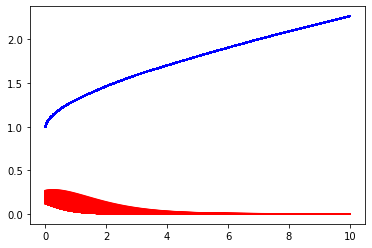

In [825]:
# initial theta 
N = 1000
theta = [1,1, 0.1]
# gradient ascend step size 
alpha = 0.01
# store theta 
THETA3 = np.zeros((2,N))
for i in range(N):
    if i%10 ==0:
        print(i)
    theta = updateTheta(theta)
    THETA3[:,i] = theta[:2]
    plot3(theta)

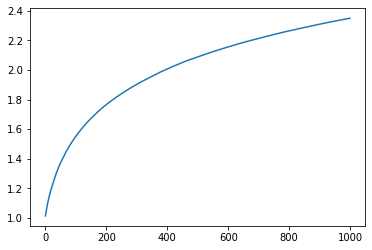

In [826]:
plt.plot(THETA3[0,:])

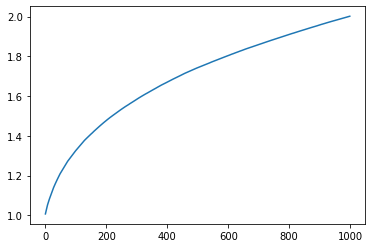

In [827]:
plt.plot(THETA3[1,:])

In [828]:
T = 20
# simulation step T = 20
def poly(theta, w):
    return theta[0] * w 

def mu(theta, w):
    return 1 / (1+np.exp(poly(theta, w)))

def simSinglePath(theta):
    wPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    w = np.random.choice(ws)
    for t in range(T):
        n = np.random.normal(mu(theta, w), theta[-1])*(w+1)
        while n < 0.01 or n > 0.99:
            n = np.random.normal(mu(theta, w), theta[-1])
        c = (w+y)*n
        wPath[t] = w
        aPath[t] = n
        rPath[t] = np.log(c)*(beta**t)
        if np.random.uniform(0,1) > 0.5:
            w = (w+y-c) * (1+r_up)
        else:
            w = (w+y-c) * (1-r_down)
    return wPath, aPath, rPath



def gradientV(theta, D = 100):
    '''
        D is the sample size
    '''
    grad = np.zeros(len(theta))
    newGrad = np.zeros(len(theta))
    for d in range(D):
        wp, ap, rp = simSinglePath(theta) 
        newGrad[0] = np.sum((ap - mu(theta, wp))*(mu(theta, wp)**2 * np.exp(poly(theta, wp)))*(-wp))
        grad += newGrad * np.sum(rp)
    grad /= D
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta 

def plot3(theta):
    def f(x):
        return mu(theta, x)
    plt.plot(ws, Cs, 'b')
    plt.plot(ws, f(ws)*(ws+1), 'r')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


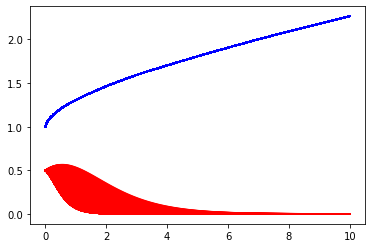

In [829]:
# initial theta 
N = 1000
theta = [1, 0.1]
# gradient ascend step size 
alpha = 0.01
# store theta 
THETA3 = np.zeros((1,N))
for i in range(N):
    if i%10 ==0:
        print(i)
    theta = updateTheta(theta)
    THETA3[:,i] = theta[:1]
    plot3(theta)

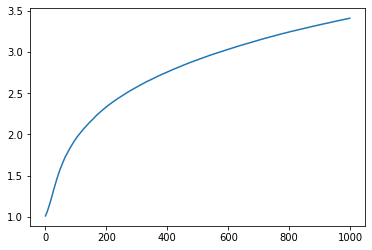

In [830]:
plt.plot(THETA3[0,:])

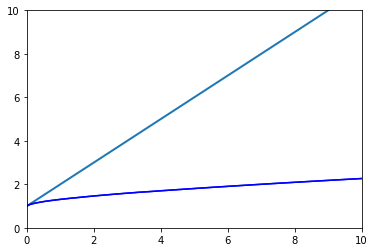

In [98]:
# First set up the figure, the axis, and the plot element we want to animate
from IPython.display import HTML
from matplotlib import animation
fig = plt.figure()
ax = plt.axes(xlim=(0, 10), ylim=(0, 10))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    plt.plot(ws, Cs, 'b')
    line.set_data([], [])
    return line,

# # animation function.  This is called sequentially
# def animate1(i):
#     def f(theta, x):
#         return np.log(theta[0]*x + theta[1]) + theta[2]
#     x = ws
#     y = f(THETA1[:,i], ws)
#     line.set_data(x, y)
#     return line,

# def animate2(i):
#     def f(theta, x):
#         return theta[0] * x + theta[1]
#     x = ws
#     y = f(THETA2[:,i], ws)
#     line.set_data(x, y)
#     return line,

def animate3(i):
    def f(theta, x):
        return (x+1) / (1+np.exp(-poly(theta, x)))
    x = ws
    y = f(THETA3[:,i], ws)
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate3, init_func=init,
           frames=1000, interval=20, blit=True)

HTML(anim.to_html5_video())

In [ ]:
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate2, init_func=init,
           frames=1000, interval=20, blit=True)

HTML(anim.to_html5_video())

In [ ]:
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate3, init_func=init,
           frames=1000, interval=20, blit=True)

HTML(anim.to_html5_video())